In [1]:
import matplotlib.pyplot as plt #For plotting our visualizations
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
from PIL import Image
import seaborn as sns

<hr/>

# Functions

In [2]:
def LoadData(image_size: tuple = (480, 640), seed: int = 1234, ds_num: int = 1, color: str = "rgb") -> tuple:
    """
    Load all the images in the given dataset folder. Since all the images in the
    dataset are already split in separate folders, this function
    will extract each and return them as a tuple of `tf.data.Dataset`, along with
    a list of the class names.

    Args:
        image_size: size the images will be processed into (h,w) 
            (default = (480,640))
        seed: random seed to shuffle the dataset with. Use `None` if randomizing
            is not required. (default = 1234)
        ds_num: the dataset number corrisponding to the folder to extract the
            dataset from. (ex. 1 = "ds1") (default = 1)
        color: the color to process the images as. ("rgb", "rgba", "grayscale)
            (default = "rbg")
    
    Returns:
        `tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset, list[string]]`
        where it is (Train, Test, Validation, and class names) respectively
    """
    train_ds = tf.keras.utils.image_dataset_from_directory(
        f"../Data/Original/ds{ds_num}/Train/",
        image_size=image_size,
        color_mode=color,
        seed=seed,
    )
    test_ds = tf.keras.utils.image_dataset_from_directory(
        f"../Data/Original/ds{ds_num}/Test/",
        image_size=image_size,
        color_mode=color,
        seed=seed,
    )
    validation_ds = tf.keras.utils.image_dataset_from_directory(
        f"../Data/Original/ds{ds_num}/Validation/",
        image_size=image_size,
        color_mode=color,
        seed=seed,
    )
    return (train_ds, test_ds, validation_ds, train_ds.class_names)

In [3]:
def PeakData(dataset: tf.data.Dataset,
             class_names: list,
             nrows: int = 3,
             ncols: int = 3,
             prediction_labels: list = None
            ) -> None:
    """
    Displays the images in the given dataset. If predictions are given, it will
    say in the title what the prediction was vs the what it actually is.

    Args:
        dataset: the dataset to view some images from
        class_names: list of the names of the classifications
        nrows: number of rows to display (default = 3)
        ncols: number of columns to display (default = 3)
        prediction_labels: list of the predictions. If None, it won't be used
            (default = None)
    """
    for images, labels in dataset.take(1):
        for i in range(nrows * ncols):
            plt.subplot(nrows, ncols, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]] if prediction_labels == None else f"pred: {class_names[prediction_labels[i]]} | actual: {class_names[labels[i]]}")
            plt.axis("off")
    plt.show()

In [4]:
def MakeModel(class_names: list) -> tf.keras.Sequential:
    """
    Simple straight forward CNN model. this is just for simplicity and testing
    atm. I will make it more modular later once I know what we are doing

    Args:
        class_names: list of the classification names
    
    Returns:
        `tf.keras.Sequential` - a constructed tf model
    """
    tf.keras.backend.clear_session()

    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(len(class_names))
        # tf.keras.layers.Rescaling(1./255),
        # tf.keras.layers.Conv2D(32, 3, activation='relu'),
        # tf.keras.layers.MaxPooling2D(),
        # tf.keras.layers.Conv2D(64, 3, activation='relu'),
        # tf.keras.layers.MaxPooling2D(),
        # tf.keras.layers.Flatten(),
        # tf.keras.layers.Dense(128, activation='relu'),
        # tf.keras.layers.Dense(len(class_names))
    ])

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

In [5]:
def ExtractLabels(dataset: tf.data.Dataset) -> list:
    """
    Take the given dataset and return a list of its labels. This can take some
    time, try to store results into a variable when you can.

    Args:
        dataset: the dataset to extract labels from
    
    Returns:
        `list[int]` - list of the labels in the dataset
    """
    return list(
        dataset.map(lambda _,y: y)
            .flat_map(tf.data.Dataset.from_tensor_slices)
            .as_numpy_iterator()
    )

In [6]:
def ConfusionMatrix(class_names: list, true_labels: list, predicted_labels: list) -> None:
    """
    Displays a confusion matrix for the predictions.

    Args:
        class_names: list of the classification names
        true_labels: labels of the dataset that was tested
        predicted_labels: list of the predictions made
    """
    # Create a confusion matrix as a 2D array.
    confusion_matrix = tf.math.confusion_matrix(true_labels, predicted_labels)

    # Use a heatmap plot to display it.
    ax = sns.heatmap(
        confusion_matrix, 
        annot=True, 
        fmt='.3g', 
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False
    )

    # Add axis labels.
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.show()

In [7]:
def EvaluateModel(model: tf.keras.Sequential, test_ds: tf.data.Dataset, history: tf.keras.callbacks.History) -> None:
    """
    Take the model and plot the training accuracy and validation accuracy. Also,
    Perform a evaluation on the test data and print the loss and accuracy.

    Args:
        model: the model to test
        test_ds: the test dataset to evaluate the model with
        history: the history from fitting the model
    """
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.show()

    test_loss, test_acc = model.evaluate(test_ds, verbose=2)
    print(f"Test loss: {test_loss} | Test accuracy: {test_acc}")

<hr/>

# Tests

Found 12479 files belonging to 13 classes.
Found 4160 files belonging to 13 classes.
Found 4160 files belonging to 13 classes.


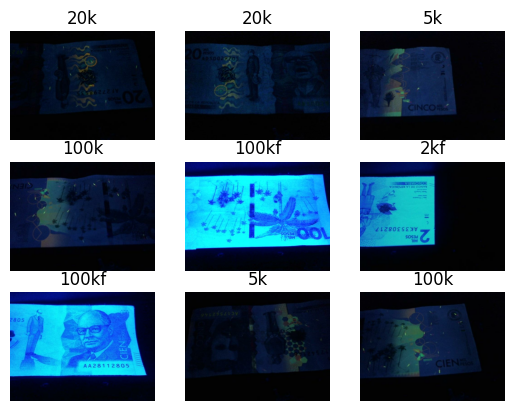

In [23]:
train_ds, test_ds, validation_ds, class_names = LoadData()
PeakData(train_ds, class_names)

In [10]:
model = MakeModel(class_names)
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=5
)

Epoch 1/5
390/390 [==============================] - 73s 162ms/step - loss: 0.7185 - accuracy: 0.7591 - val_loss: 0.1098 - val_accuracy: 0.9685
Epoch 2/5
390/390 [==============================] - 61s 155ms/step - loss: 0.0508 - accuracy: 0.9848 - val_loss: 0.0282 - val_accuracy: 0.9930
Epoch 3/5
390/390 [==============================] - 60s 154ms/step - loss: 0.0404 - accuracy: 0.9871 - val_loss: 0.0249 - val_accuracy: 0.9921
Epoch 4/5
390/390 [==============================] - 62s 159ms/step - loss: 0.0151 - accuracy: 0.9947 - val_loss: 0.0050 - val_accuracy: 0.9986
Epoch 5/5
390/390 [==============================] - 64s 163ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.0015 - val_accuracy: 0.9993


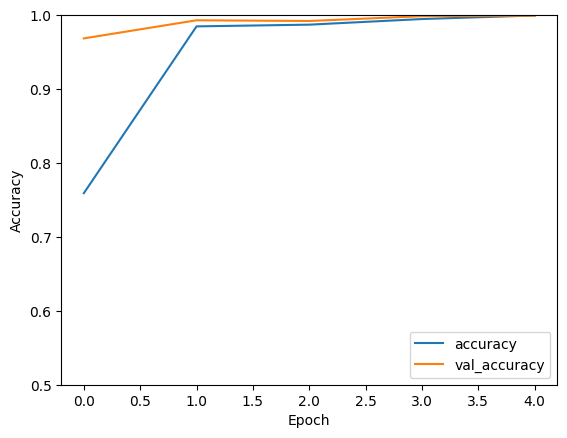

130/130 - 10s - loss: 7.6141e-04 - accuracy: 0.9998 - 10s/epoch - 78ms/step
Test loss: 0.0007614107453264296 | Test accuracy: 0.9997596144676208


In [11]:
EvaluateModel(model, test_ds, history)

In [16]:
y_pred = []
y_true = []
tf.keras.backend.clear_session()
for image_batch, label_batch in test_ds.take(1):
    y_true.append(tf.concat(label_batch, axis=0))
    predictions = model.predict(test_ds)
    prediction_labels = tf.argmax(predictions, axis=1)
    y_pred.append(prediction_labels)

130/130 [==============================] - 5s 36ms/step


In [50]:
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [51]:
ConfusionMatrix(class_names, correct_labels, prediction_labels)

InvalidArgumentError: {{function_node __wrapped__Pack_N_2_device_/job:localhost/replica:0/task:0/device:GPU:0}} Shapes of all inputs must match: values[0].shape = [32] != values[1].shape = [4160] [Op:Pack] name: stack

In [14]:
y_true

[<tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([ 0, 11,  4,  8, 11, 10,  2,  2,  5, 10,  6,  6, 12,  3, 11,  8,  4,
         4,  3,  6, 11,  4,  7,  9, 12,  1,  2,  0,  1,  1,  5,  7],
       dtype=int32)>]

In [15]:
y_pred

[<tf.Tensor: shape=(4160,), dtype=int64, numpy=array([6, 0, 2, ..., 6, 3, 3])>]

In [34]:
prediction_labels[:10]

array([ 4,  5, 11,  6,  7,  2,  7,  4,  3, 12])

# Visualizations

4 4


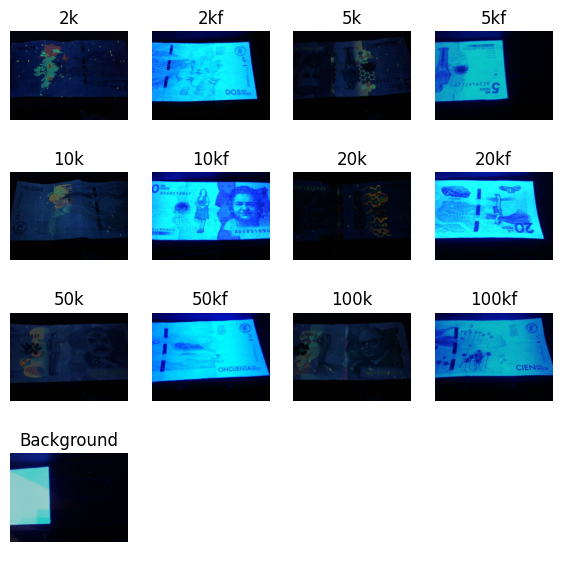

In [61]:
i = 0
c_names = ["2k", "2kf", "5k", "5kf", "10k", "10kf", "20k", "20kf", "50k", "50kf", "100k", "100kf", "Background"]
cols = 4
rows = int(13/cols) + 1
print(cols, rows)
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(7,7))
for images, labels in test_ds:
    j = -1
    while i < 13 and j + 1 < 32:
        j += 1
        if class_names[labels[j]] != c_names[i]:
            continue
        axs[int(i / cols)][i % cols].imshow(images[j].numpy().astype("uint8"))
        axs[int(i / cols)][i % cols].set_title(class_names[labels[j]])
        axs[int(i / cols)][i % cols].axis("off")
        i += 1
    if i >= 13:
        break
axs[3][1].axis("off")
axs[3][2].axis("off")
axs[3][3].axis("off")
plt.show()